# METROID - Morphological Extraction of Transmembrane potential from Regions Of Interest Device

**main function: metroid(** *fpath, FR, transitory, n_ROIs_out=16, n_ROIs_in=16, t_sig_onset=None, t_sig_end=None, method='ICA', n_comp=2, wavelet='Haar', autoselect='auto', mask_method='load'* **)**

Divide mask into ROIs of approximately equal area, get ROIs means over time from video, remove phtobleaching and delete noise.

Gets video(s) and mask(s) from *fpath*. Uses frame rate information (*FR*) to build a time array. Uses *transitory* information to apply adequate filtering method. Divides cell mask into two major regions (inner and outter region), then divide these regions into smaller regions of interest (ROIs) with similar area following cell shape. The number of ROIs in each major region can be adjusted by *n_ROIs_out* and *n_ROIs_in* arguments. Also, get ROIs means over time from video (*ROIs_means*).
Then, if not provided, estimates time instants when signal starts and ends (*t_sig_prop*). For each column of *ROI_means*, subtracts a decreasing function representing photobleaching. Such function is obtained by best curve fit ([SciPy curve_fit function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html)) using a combination of exponential and linear (and step if transitory=*False*) functions. The result of this stage is stored in *ROIs_means_corrected*.
After that, estimates noise power from time intervals when signal is absent. Then, applies a BSS method defined by *method* (with the wavelet filtering defined by *wavelet* if 'wPCA' or 'wICA' are chosen) and selects one or more components as representing the sources of the signal(s). Source selection can be manual or automatic depending on *autoselect*. If *autoselect='manual'*, components are plotted and user must type source(s) number(s). If *autoselect='auto'*, source selection is done based on portions of the components that are higher than 2 times the noise standard deviation (only 1 source is selected when using *autoselect*='auto'). After that, inverse transformation is executed to rebuild ROIs means using just the selected source(s) (*ROIs_means_filtered*). Finally, signal power is calculated, as well as Signal-to-Noise Ratio (SNR) in each ROI.

**Parameters:**  
- **fpath: str**
    - path to directory containing files (videos and/or masks).
- **FR: float or list**
    - video(s) frame rate (in frames per second). If more than 1 video, allframe rates should be provided as a list of floats.
- **transitory: bool or NoneType**
    - transitory=*True* if signal is transitory. transitory=*False* if signal is perduring (like a step). transitory=*None* if no signal is present.
- **n_ROIs_out: int, optional**
    - number of ROIs in the outter region. Minimum of 2.
- **n_ROIs_in: int, optional**
    - number of ROIs in the inner region. Minimum of 4.
- **t_sig_onset: float, optional**
    - time instant (in seconds) when signal is supposed to start. If *None*, it will be estimated by highest first derivative instant.
- **t_sig_end: float, optional**
    - time instant (in seconds) when signal is supposed to end. If *None*, it will be estimated by t_sig_onset + duration while signal amplitude remains bigger than twice the noise standard deviation (which is estimated from instants before t_sig_onset).
- **method: string, optional**
    - *PCA*, *ICA*, *wPCA* or *wICA*.
- **n_comp: int, optional**
    - Number of components to allocate estimated sources (same as *n_components* input in [FastICA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.fastica.html#sklearn.decomposition.fastica) and [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA)) . n_comp=2 means to separate into 2 components for later source selection (only 1 source is selected if autoselect='auto').
- **wavelet: string, optional**
    - string representing the wavelet to be used (same as in [Pywavelets](https://pywavelets.readthedocs.io/en/latest/ref/wavelets.html#wavelet-families)). Tested wavelets are 'dmey' and 'Haar'.
- **autoselect: string, optional**
    - string that determines whether source selection will be done manually (autoselect='manual') or automatically (autoselect='auto').
- **mask_method: string, optional**
    - string that defines if cell mask will be loaded from a image file (black and white 8-bit ".tif" image) in the same folder with the word 'mask' in the file name (mask_method = 'load') or if the mask will be drawn by user (mask_method = 'draw') in which case a drawing interface appears and code is halted until user clicks on button 'Done'. Drawn masks are saved in the same folder with 'manualmask' in the file name. Does not work if metroid is imported, i.e., only works if executed inside this metroid notebook.
 
**Returns:**  
- **stack_ROIs: boolean array**
    - (R x M x N) image stack, where R are ROI numbers (R = n_ROIs_in + n_ROIs_out), M are lines and N are columns.
- **label_ROIs: boolean array**
    - (M x N) image, where each ROI is labeled by different numbers in the image (0 for background), M are lines and N are columns.
- **ROIs_means_filtered: array**
    - (F x R) array, where F are frames and R are ROI numbers.
- **time: array**
    - (F,) array, where F are time points.
- **ROIs_means: array**
    - (F x R) array, where F are frames and R are ROI numbers.
- **ROIs_means_corrected: array**
    - (F x R) array, where F are frames and R are ROI numbers.
- **mask_list: list of boolean arrays**
    - list of (M x N) arrays, M are lines and N are columns.
- **components: array**
    - (F x n_comp) array, where F are frames and n_comp is the number of components.
- **selected_source_idx: int**
    - index of the selected source.
- **t_sig_properties: tuple of floats**
    - first element is time when signal starts and second element is time when signal ends (returns *None* if *transitory==False/None*).
- **SNR_dB: array**
    - (R,) array, where R are ROI numbers.

In [34]:
testing = (__name__ == "__main__")
if testing:
    %matplotlib inline
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    import numpy as np
    import sys,os

    metroidpath = os.path.abspath('')
    if metroidpath not in sys.path:
        sys.path.append(metroidpath)
    items = os.listdir(metroidpath)
    if 'MESS.py' not in items:
        ! jupyter nbconvert --to 'python' MESS.ipynb
    if 'Remove_Photobleaching.py' not in items:
        ! jupyter nbconvert --to 'python' Remove_Photobleaching.ipynb
    if 'BSSD.py' not in items:
        ! jupyter nbconvert --to 'python' BSSD.ipynb
    import MESS as mes
    import Remove_Photobleaching as rpb
    import BSSD as bssd

## Mandatory parameters:

In [35]:
if testing:
    global fpath
    fpath = 'Data\\Cell1\\videos_AP'
    # fr_list = [55.78, 55.78, 55.78, 55.67] #Cell1
    # fr_list = [71.29, 71.29, 71.29, 71.15] #Cell2
    fr_list = [55.78]
    transitory=True

## Optional parameters (all automatic):

In [36]:
# if testing:
#     mask_method='load' #or 'draw' if you want to draw masks here
#     t_sig_onset = 0.5
#     t_sig_end = 1
#     method = 'ICA'
#     n_comp=2
#     wavelet = 'dmey'
#     autoselect='auto'

# METROID functions:

In [37]:
def get_img_stacks(folder):
    '''Gets image stacks in .tif format
       Stacks order should be defined by the last character in each name'''
    from skimage import io
    import os
    items = os.listdir(folder)
    stacks_names = []
    fext='.tif'
    for fname in items:
        if fname.endswith(fext):
            stacks_names.append(fname)
    if stacks_names==[]:
        print("No .tif files found in ", folder)
        return
    else:
        def last_character(name):
            return name[-5]
        stacks_names.sort(key=last_character)
        video_list = []
        for fname in stacks_names:
            fullpath = folder + '\\' + fname
            f = io.imread(fullpath)
            if len(f.shape)>2: #Get only videos, single 8/16-bit images are not included
                if f.shape[-1]>3: # rgb images are not included (as a side-effect videos of up to 3 frames are not included)
                    video_list.append(f)
        return(video_list)

In [38]:
def load_masks(video_list,folder=None,mask_method='load'):
    '''Load cell masks from dir
       Cell masks should be binary images with the same shape (lin, col) as the videos
       If there are no cell masks, this function produces an approximated cell mask for each video'''
    import numpy as np
    from skimage import io
    import os
    
       
    items = os.listdir(folder)
    stacks_names = []
    fext='.tif'
    for fname in items:
        if fname.endswith(fext):
            stacks_names.append(fname)
    # checks whether there are .tif files in directory
    if stacks_names==[]:
        print("No .tif files found in ", folder)
        return
    else:
        def last_character(name):
            return name[-5]
        stacks_names.sort(key=last_character)
        b_satlist = []
        for fname in stacks_names:
            if "mask" in fname:
                if mask_method=='draw':
                    if "manual" in fname:
                        fullpath = folder + '\\' + fname
                        b = io.imread(fullpath)
                        if len(b.shape)<3:
                            b_satlist.append(b.astype(bool))
                else:
                    if "manual" not in fname:
                        fullpath = folder + '\\' + fname
                        b = io.imread(fullpath)
                        if len(b.shape)<3:
                            b_satlist.append(b.astype(bool))
        if len(b_satlist)==0:
            print("No images named 'mask' found in ", folder)
            return
    return(b_satlist)

# Main Function:

In [39]:
def metroid(fpath,FR,transitory,n_ROIs_out=16,n_ROIs_in=16,t_sig_onset=None,t_sig_end=None,method='ICA',n_comp=2,wavelet='Haar',autoselect='auto',mask_method='load'):
    import numpy as np
    import MESS as mes
    import Remove_Photobleaching as rpb
    import BSSD as bssd
    if type(FR) is not list:
        FR = [FR]
    video_list = get_img_stacks(fpath)
    mask_list = load_masks(video_list, fpath, mask_method)

    while(len(video_list)>len(mask_list)):
        mask_list.append(mask_list[0])
    
    ROIs_means_list = []
    for video,fr,mask in zip(video_list,FR,mask_list):
        stack_ROIs, label_ROIs, ROIs_means, time  = mes.segment(mask,video, fr, n_ROIs_out, n_ROIs_in)
        ROIs_means_list.append(ROIs_means)
    if len(video_list)>1:
        ROIs_means = np.mean(ROIs_means_list,axis=0)
        FR = np.mean(FR)
        video = video_list[-1]
        mask = mask_list[-1]
        time = mes.build_time_vector(fr,video.shape)
      
    ROIs_means_corrected, inactive_msk,t_sig_onset,t_sig_end  = rpb.photob_remove(video,time, mask,ROIs_means,transitory,t_sig_onset,t_sig_end)
    if transitory==None:
        return(stack_ROIs,label_ROIs,None,time,ROIs_means,ROIs_means_corrected,mask_list,None,None,None,None)
    ROIs_means_filtered,components,selected_source_idx,SNR_dB = bssd.denoise(ROIs_means_corrected,time,inactive_msk,t_sig_onset,method,n_comp,wavelet,autoselect)
    return(stack_ROIs,label_ROIs,ROIs_means_filtered,time,ROIs_means,ROIs_means_corrected,mask_list,components,selected_source_idx,(t_sig_onset, t_sig_end),SNR_dB)

# Test
## Load previously stored masks: 

## Run METROID:

In [40]:
if testing:
    stack_ROIs, label_ROIs, ROIs_means_filtered, time, \
    ROIs_means, ROIs_means_corrected, mask_list, \
    components, selected_source_idx, t_sig_prop, \
    SNR_dB = metroid(fpath,fr_list,transitory)

## Plot results
### Regions of interest

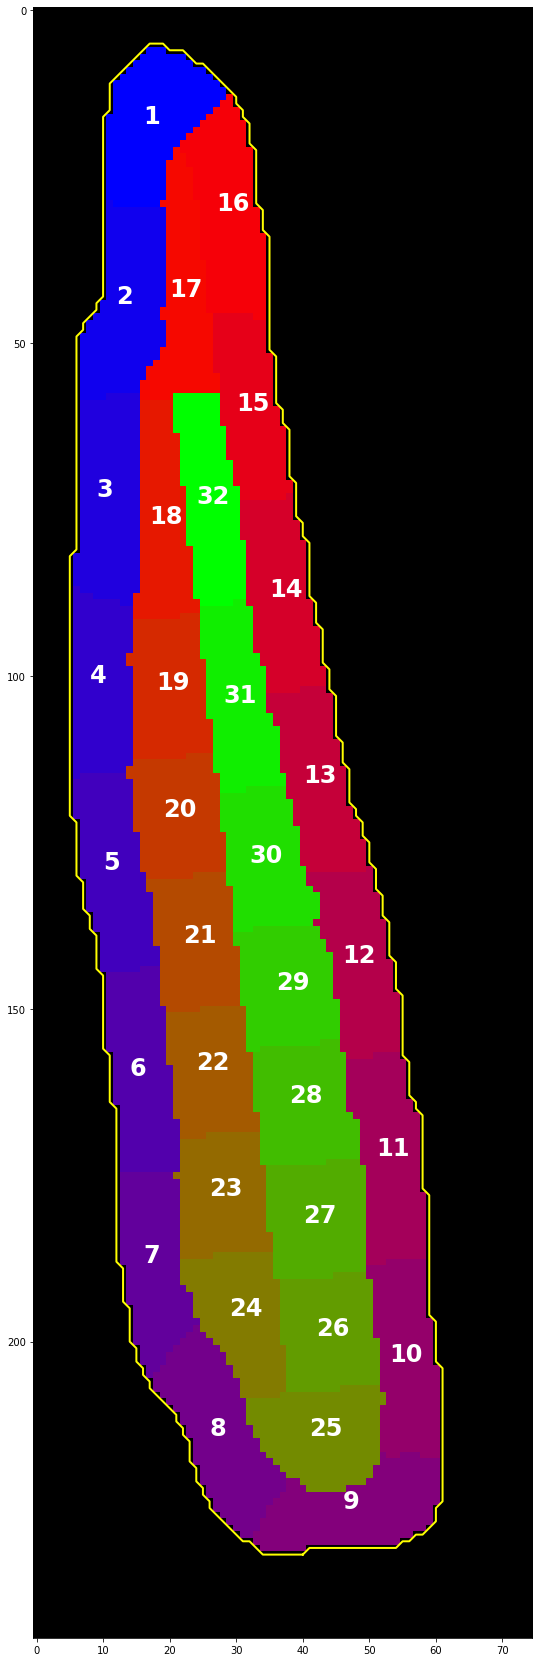

In [41]:
if testing:
    nregions = np.amax(label_ROIs).astype(int)
    ncolors = nregions
    from matplotlib import cm
    from matplotlib.colors import ListedColormap
    brg = cm.get_cmap('brg', nregions)
    newcolors = np.tile((np.arange(0,ncolors))/(ncolors-1),nregions//(ncolors-1))
    newcolors = newcolors[:nregions]
    newcolors = brg(newcolors)
    black = np.array([0, 0, 0, 1])
    newcolors = np.insert(newcolors,0,black,axis=0)
    newcmp = ListedColormap(newcolors)
    
    fig, ax = plt.subplots(figsize=[10,30],nrows=1, ncols=1)
    ax.imshow(label_ROIs, cmap=newcmp)

    cent_coord = np.zeros((nregions,2))

    for j in range(nregions):
        cent_coord[j,:] = np.rint(mes.get_centroid(stack_ROIs[j,:,:]))
        ax.annotate(j+1,(cent_coord[j,0]-2,cent_coord[j,1]),xycoords='data',color='white',fontsize=24,weight='bold')
    video_list = get_img_stacks(fpath)
    mask_list = load_masks(video_list, fpath)
    contour = mes.build_contour(mask_list[0])
    ax.plot(contour[:,1],contour[:,0],color='yellow',lw=2)

### ROIs means over time

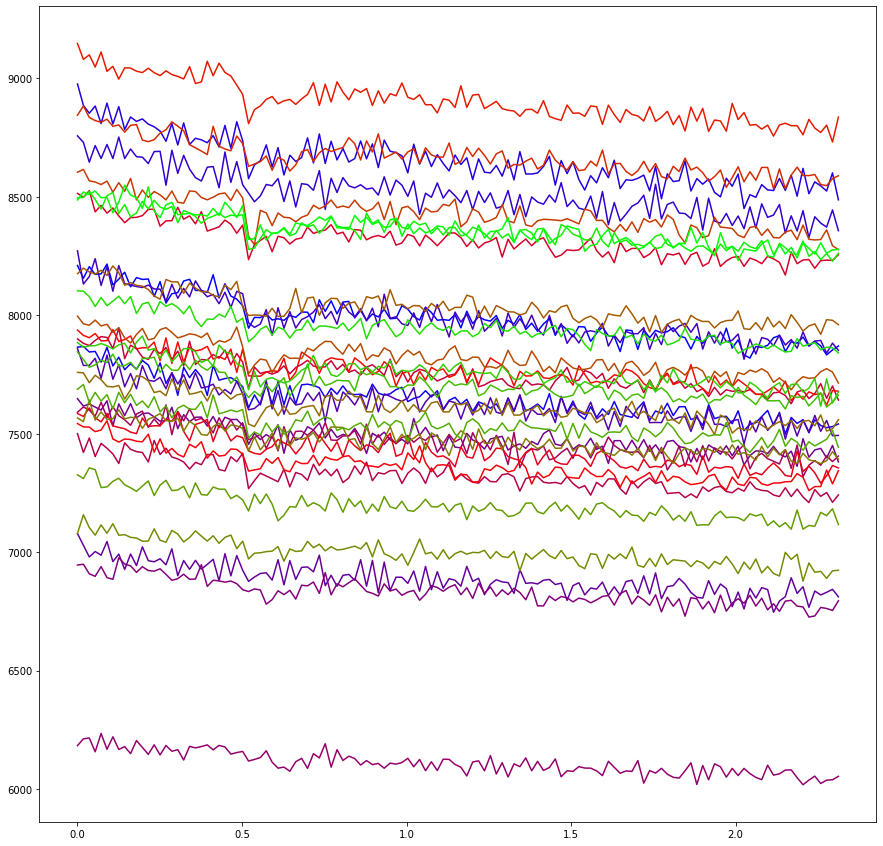

In [42]:
if testing:
    fig, ax1 = plt.subplots(figsize=[15,15])
    for i in range(nregions):
        ax1.plot(time,ROIs_means[:,i],color=newcolors[i+1])

### Fixed photobleaching

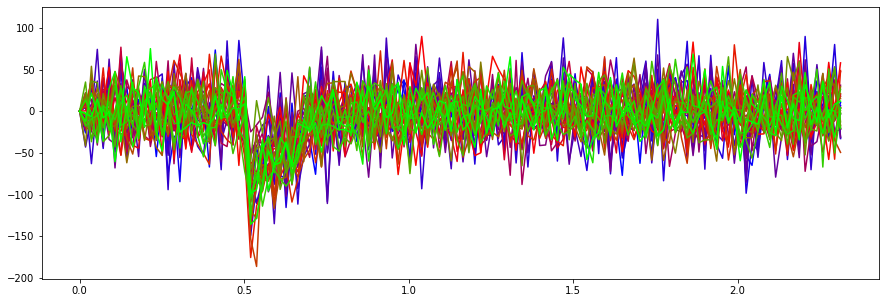

In [43]:
if testing:
    fig, ax1 = plt.subplots(figsize=[15,5])
    for i in range(nregions):
        ax1.plot(time,ROIs_means_corrected[:,i],color=newcolors[i+1])

### Filtered signals

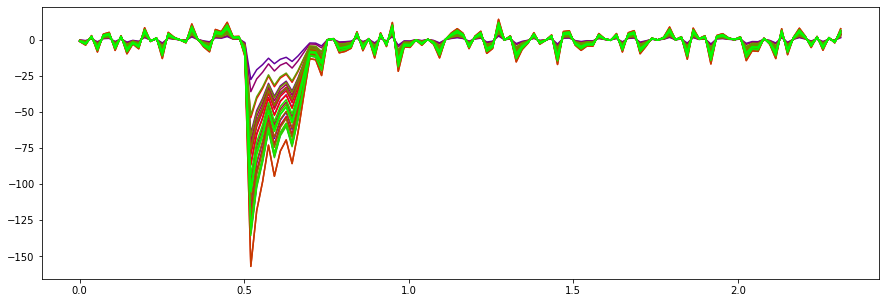

In [44]:
if testing:
    fig, ax1 = plt.subplots(figsize=[15,5])
    for i in range(nregions):
        ax1.plot(time,ROIs_means_filtered[:,i],color=newcolors[i+1])

# Test2 (draw mask: manual; select sources: manual)

## Optional parameters (all manual, example with 4 components):

In [45]:
if testing:
    mask_method='draw' #or 'load' if you have already saved mask files
    t_sig_onset = 0.5
    t_sig_end = 0.8
    method = 'wICA'
    n_comp=4
    wavelet = 'dmey'
    autoselect='manual'

### Manual drawing or automatic drawing (with possible manual adjustments)
__Uses the lasso tool:__
    
* Click and hold over the imge to draw shapes
* Try to follow cell external membrane
* Erase button: click once on this button and all new shapes drawn over the previous one will erase where they intersect
* Draw button: click once to be able to add new shapes into your previous shape (union). If 2 shapes do not overlap, only the biggest shape remains.
* Auto button: automatically draws an approximate shape over image based on each fluorescence video. May draw more than one shape depending on the number of fluorescence videos inside folder. Draw and Erase buttons allow edition over the last (highest number in legend) automatically generated shape, so both will become equal afterwards.
* Done button: Closes the drawing interface, saves the masks into the folder (wiht 'manual' in their names) and allows code execution to proceed.

<IPython.core.display.Javascript object>


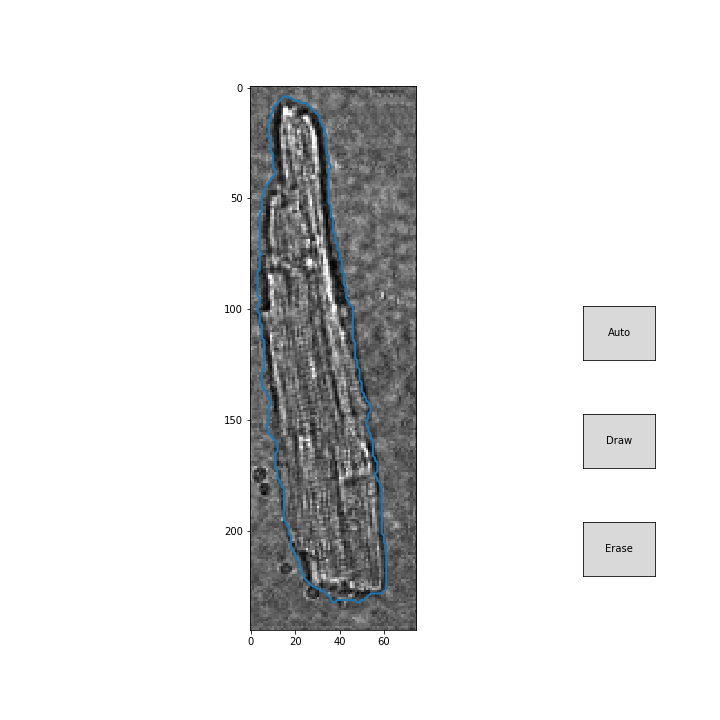

Button(description='Done', layout=Layout(border='solid 5px', height='80px', margin='0px 0px 0px 350px', width=…

Output()

In [48]:
if testing:
#     global mask, fig_draw, ax_draw, video_list, im, b_satlist, pix, done, erase
    b_satlist = []
    done = False
    video_list = get_img_stacks(fpath)
    if mask_method=='draw':
        
        #change backend so user can interact with it
        %matplotlib notebook
        %matplotlib notebook
        import matplotlib.pyplot as plt
        
        from matplotlib.widgets import LassoSelector
        from matplotlib.widgets import Button
        from ipywidgets import Button as wButton
        from ipywidgets import Output, Layout
        from skimage import io
        # Show snap image
        fig_draw, ax_draw = plt.subplots(figsize=[10,10])
        im_address = fpath + '//snap.tif'
        im = io.imread(im_address)
        #If snap is in RGB format, change it to grayscale (8-bits)
        if len(im.shape)>2:
            from skimage.color import rgb2gray
            im = rgb2gray(im)*255
        ax_draw.imshow(im, cmap='gray')
        plt.subplots_adjust(right=0.8)
        x, y = np.meshgrid(np.arange(im.shape[1]), np.arange(im.shape[0]))
        pix = np.vstack((x.flatten(), y.flatten())).T
        #creates empty mask
        mask = np.zeros_like(im).astype(bool)
        #global variable that define if drawing or erasing shape
#         fig_draw.canvas.draw_idle()
        erase = False
        def onselect(verts):
            from matplotlib.path import Path
            from skimage.measure import label, regionprops
            from skimage.morphology import remove_small_holes
            from MESS import build_contour
            global erase, mask, b_satlist, video_list, fig_draw, ax_draw, im, pix
            b_satlist = []
            ax_draw.axes.clear()
            ax_draw.imshow(im, cmap='gray')
            # Select elements in original array bounded by selector path:
            p = Path(verts)
            ind = p.contains_points(pix, radius=1)
            selected = np.zeros_like(im)
            selected.flat[ind] = im.flat[ind]
            if erase==False:
                mask[selected>0] = True
            else:
                mask[selected>0] = False
                
            #If the user draws more than one element, retain only the biggest
            label_image = label(mask, background=0)
            global props
            props = regionprops(label_image, coordinates='xy')
            def myFunc(e):
                return(e.area)
            props.sort(key=myFunc,reverse=True)
            while len(props)>1:
                props.pop()
            #Redraw the mask with only the biggest element
            mask[:,:] = False
            mask[props[0].coords[:,0],props[0].coords[:,1]] = True
            #removes internal holes
            remove_small_holes(mask,props[0].area,in_place=True)
            #Generates the contour to display over image
            contour = build_contour(mask)
            for i in range(len(video_list)):
                b_satlist.append(mask.astype(bool))
            ax_draw.plot(contour[:,1],contour[:,0],lw=2)
            fig_draw.canvas.draw_idle()

        #lasso tool to manually draw/erase shape
        lineprops = {'color': 'red', 'linewidth': 2, 'alpha': 0.8}
        lasso = LassoSelector(ax_draw, onselect,lineprops=lineprops,useblit=False)

        class ManualDraw(object):
            ind = 0
            def draw_activation(self, event):
                global erase
                erase=False
            def erase_activation(self, event):
                global erase
                erase=True
            
            def on_auto(self,event):
                from MESS import build_contour
                global video_list, mask, fig_draw, ax_draw, b_satlist, im
                ax_draw.axes.clear()
                ax_draw.imshow(im, cmap='gray')
                #clear mask
                mask[:,:] = False
                from skimage.filters import threshold_otsu, threshold_local
                from skimage.morphology import remove_small_objects
                from skimage.segmentation import clear_border
                import scipy.ndimage as sm
                b_satlist = []
                for v,i in zip(video_list,range(len(video_list))):
                    #get video/image type
                    ptype = str(v.dtype)
                    if ptype.startswith('uint'):
                        pixel_depth = int(ptype[4:])
                    #estimate number of pixel additions until saturation
                    f0mean = np.mean(v[0])
                    temp = (2**pixel_depth)//f0mean
                    n_sum_til_saturation=temp.astype(int)

                    f_sat = np.zeros_like(v[0],dtype='uint32')
                    b_sat = np.zeros_like(v[0],dtype='bool')

                    #add first images pixel by pixel until some pixels saturate
                    for j in range(n_sum_til_saturation-1):
                        f_sat = np.add(f_sat,v[j])
                    #Identify which pixels are overflown
                    sat_values = f_sat>(2**pixel_depth)-1
                    #Set overflown pixels to max value based on pixel depth
                    f_sat[sat_values] = (2**pixel_depth)-1
                    #Small blur
                    f_sat = sm.gaussian_filter(f_sat,sigma=2)

                    f_sat = f_sat.astype(v.dtype)
                    #Get image dimensions
                    min_dim = np.amin(b_sat.shape)
                    max_dim = np.amax(b_sat.shape)
                    #Define block_size for local Thresholding
                    block_size = (min_dim//2)
                    #It must be odd (requirement of 'threshold_local')
                    if block_size%2==0:
                        block_size+=1
                    #Make saturated image binary with local threshold
                    thresh = threshold_local(f_sat, block_size, method='gaussian', offset=0, mode='reflect')#, cval=np.amin(f_sat))
                    b_sat = f_sat > thresh
                    #Morphological operations to close holes, connect parts, remove smaller objects
                    #Overall effect of smoothing shape
                    b_sat = sm.binary_opening(b_sat,iterations=2)
                    b_sat = sm.binary_closing(b_sat,iterations=3)
                    b_sat = sm.binary_fill_holes(b_sat)
                    b_sat = remove_small_objects(b_sat,(max_dim*min_dim)//10)
#                     print((max_dim*min_dim)//10)
                    # Remove artifacts connected to image border
                    b_sat = clear_border(b_sat)
                    mask=b_sat.astype(bool)
                    #Generates the contour to display over image
                    contour = build_contour(mask)
                    b_satlist.append(mask.astype(bool))
                    ax_draw.plot(contour[:,1],contour[:,0],lw=2,label='mask_vid_'+str(i+1))
                ax_draw.legend(loc=(1.04,1))
                fig_draw.canvas.draw_idle()
        
        def on_bok_clicked(b):
            import warnings
            from skimage import img_as_ubyte
            from skimage import io
            global video_list, b_satlist, fpath, done
            if len(b_satlist)>0:
                done = True
                #disables user interaction with image
                get_ipython().magic('matplotlib inline')
                for i in range(len(video_list)):
                    #Save masks in same folder as videos
                    impath = fpath + '//manualcellmask' + str(i+1) + '.tif'
                    io.imsave(impath, img_as_ubyte(b_satlist[i]))
            else:
                warnings.warn("No mask drawn, please run this cell again, draw a mask or click on the \'Auto\' button before clicking on \'Done\'", UserWarning)
        
        #Set buttons Draw, Erase, Auto and Done
        callback = ManualDraw()
        axauto = plt.axes([0.81, 0.5, 0.1, 0.075])
        axdraw = plt.axes([0.81, 0.35, 0.1, 0.075])
        axerase = plt.axes([0.81, 0.20, 0.1, 0.075])
#         axok = plt.axes([0.81, 0.05, 0.1, 0.075])
        bdraw = Button(ax=axdraw, label='Draw')
        bdraw.on_clicked(callback.draw_activation)
        berase = Button(ax=axerase,label='Erase')
        berase.on_clicked(callback.erase_activation)
        bok = wButton(description="Done",style = {'font_weight': 'bold', 'button_color': 'green'},
                      layout=Layout(width='25%', height='80px',margin='0px 0px 0px 350px', border='solid 5px'))
        output = Output()
        display(bok, output)
        bok.on_click(on_bok_clicked)
#         bok = Button(ax=axok, label='Done')
#         bok.on_clicked(callback.on_OK)
        bauto = Button(ax=axauto, label='Auto')
        bauto.on_clicked(callback.on_auto)
        fig_draw.canvas.draw_idle()

In [49]:
if testing:
    if mask_method=='draw':
        if done==False:
            raise NameError('No mask drawn!! Run again the cell above this one, draw a contour (or click \'Auto\'), then click \'Done\' Button to finish drawing interface')

__TIP: If you managed to stop the error message above (by drawing a mask), with this cell selected, try clicking on 'Cell->Run All Below' in this notebook menus to execute all the code below at once__

## Run METROID:

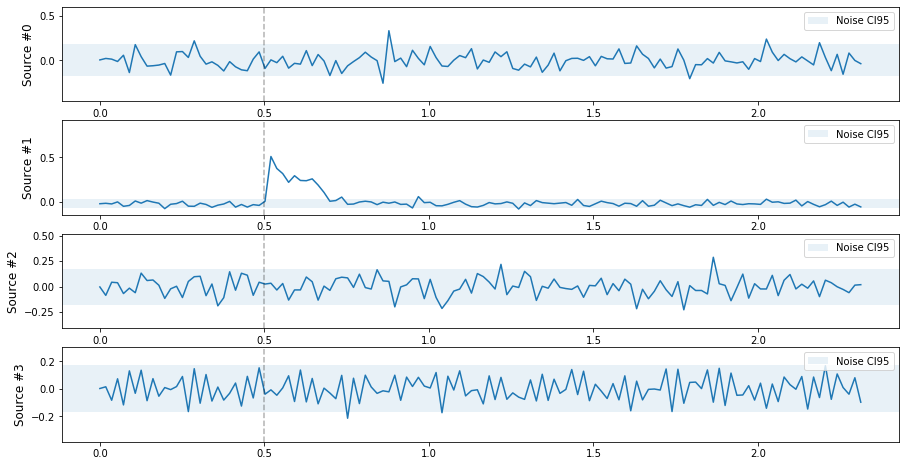

Enter one or more sources number (separate numbers by "," if number of sources > 1): 1


In [50]:
if testing:
    stack_ROIs, label_ROIs, ROIs_means_filtered, time, \
    ROIs_means, ROIs_means_corrected, mask_list, \
    components, selected_source_idx, t_sig_prop, \
    SNR_dB = metroid(fpath,fr_list,transitory,16,16,t_sig_onset,t_sig_end,method,n_comp,wavelet,autoselect,mask_method)

## Plot results
### Regions of interest

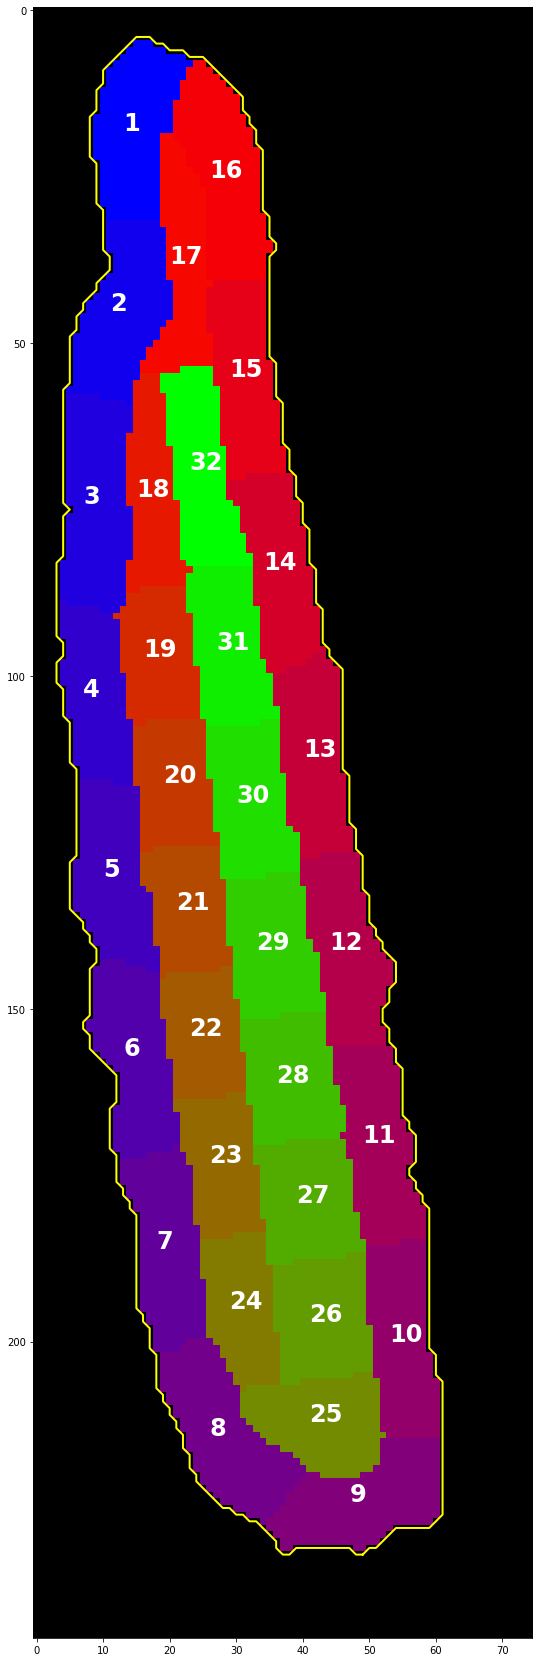

In [51]:
if testing:
    nregions = np.amax(label_ROIs).astype(int)
    ncolors = nregions
    from matplotlib import cm
    from matplotlib.colors import ListedColormap
    brg = cm.get_cmap('brg', nregions)
    newcolors = np.tile((np.arange(0,ncolors))/(ncolors-1),nregions//(ncolors-1))
    newcolors = newcolors[:nregions]
    newcolors = brg(newcolors)
    black = np.array([0, 0, 0, 1])
    newcolors = np.insert(newcolors,0,black,axis=0)
    newcmp = ListedColormap(newcolors)
    
    fig, ax = plt.subplots(figsize=[10,30],nrows=1, ncols=1)
    ax.imshow(label_ROIs, cmap=newcmp)

    cent_coord = np.zeros((nregions,2))

    for j in range(nregions):
        cent_coord[j,:] = np.rint(mes.get_centroid(stack_ROIs[j,:,:]))
        ax.annotate(j+1,(cent_coord[j,0]-2,cent_coord[j,1]),xycoords='data',color='white',fontsize=24,weight='bold')
    video_list = get_img_stacks(fpath)
    mask_list = load_masks(video_list, fpath, mask_method='draw')
    contour = mes.build_contour(mask_list[0])
    ax.plot(contour[:,1],contour[:,0],color='yellow',lw=2)

### ROIs means over time

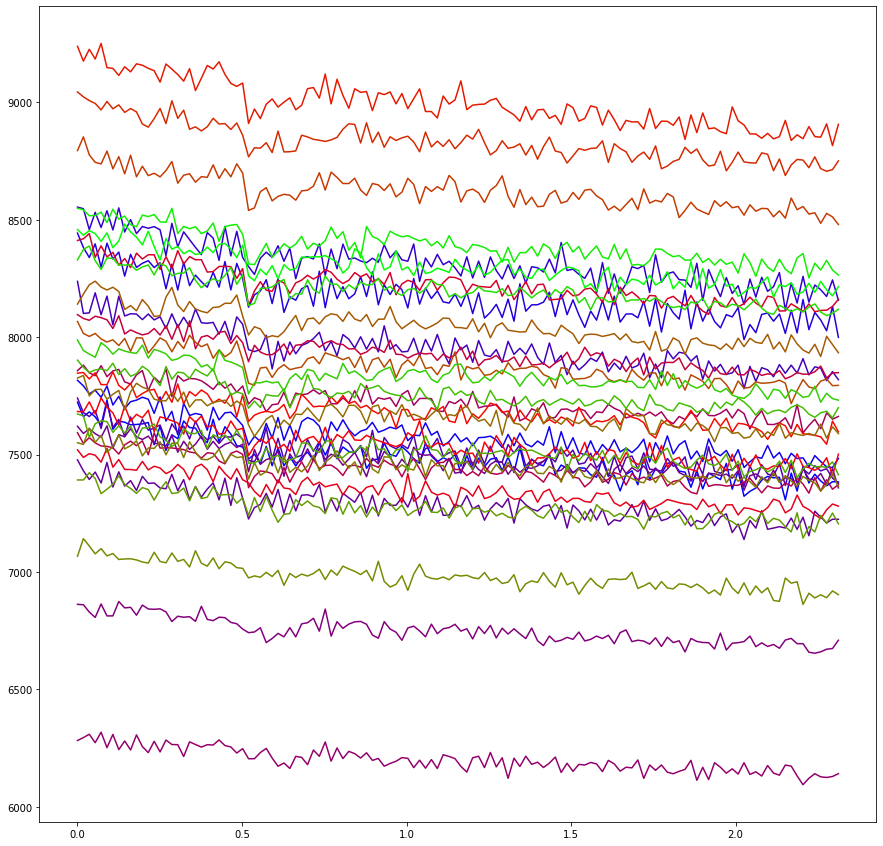

In [52]:
if testing:
    fig, ax1 = plt.subplots(figsize=[15,15])
    for i in range(nregions):
        ax1.plot(time,ROIs_means[:,i],color=newcolors[i+1])

### Fixed photobleaching

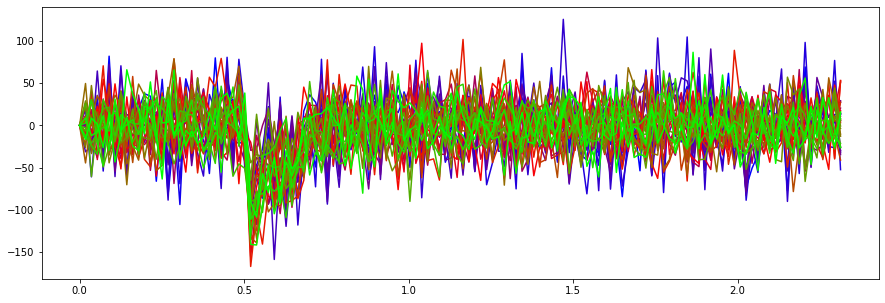

In [53]:
if testing:
    fig, ax1 = plt.subplots(figsize=[15,5])
    for i in range(nregions):
        ax1.plot(time,ROIs_means_corrected[:,i],color=newcolors[i+1])

### Filtered signals

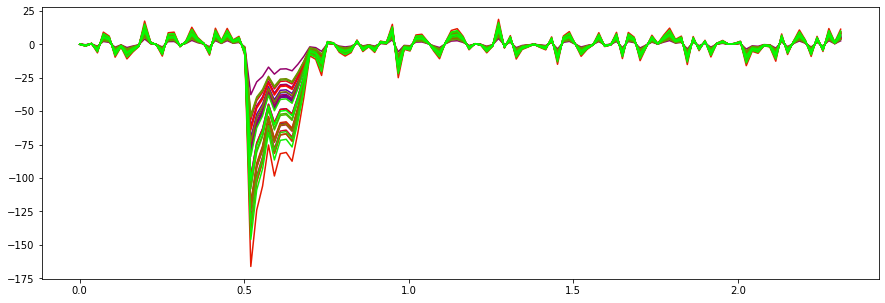

In [54]:
if testing:
    fig, ax1 = plt.subplots(figsize=[15,5])
    for i in range(nregions):
        ax1.plot(time,ROIs_means_filtered[:,i],color=newcolors[i+1])

# Time of main function execution:

In [55]:
if testing:
    %timeit stack_ROIs, label_ROIs, ROIs_means_filtered, time, \
    ROIs_means, ROIs_means_corrected, mask_list, \
    components, selected_source_idx, t_sig_prop, \
    SNR_dB = metroid(fpath,fr_list,transitory,16,16,t_sig_onset,t_sig_end,method,n_comp,wavelet,'auto','load')

1.28 s ± 103 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
